In [111]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from scratch.algos.rays import compute_cdf
import numpy as np

plt.rcParams.update({
    'font.family': 'serif'
})

In [2]:
def compute_alpha(func, x, d):
    a = 1. - torch.exp(-func(x) * d)
    return a

raw_features = torch.linspace(-20, 20, 10001)
pretty_d = {
    1e3: "1e3",
    1e2: "1e2",
    1e1: "1e1",
    1e0: "1e0",
    1e-1: "1e-1",
    1e-2: "1e-2",
    1e-3: "1e-3",
}

The following code block applies the $\mathtt{exp}$ activation function onto the raw feature vectors.

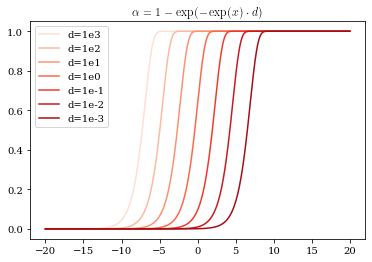

In [3]:
fig, ax = plt.subplots()
red_shades = sns.color_palette("Reds", 7)
for distance_scale in [1e3, 1e2, 1e1, 1e0, 1e-1, 1e-2, 1e-3]:
    sigmas = compute_alpha(torch.exp, raw_features, distance_scale)
    ax.plot(raw_features, sigmas, label=f"d={pretty_d[distance_scale]}", color=red_shades.pop(0))

ax.set_title(r"$\alpha = 1 - \exp(-\exp(x) \cdot d)$", fontsize=12, usetex=True)
ax.legend(fontsize=10)
plt.savefig('exp.pdf', bbox_inches='tight', dpi=300)
plt.show()

The following code block applies the $\mathtt{softplus}$ activation function onto the raw feature vectors.

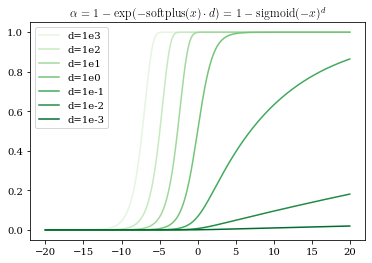

In [4]:
fig, ax = plt.subplots()
green_shades = sns.color_palette("Greens", 7)
for distance_scale in [1e3, 1e2, 1e1, 1e0, 1e-1, 1e-2, 1e-3]:
    sigmas = compute_alpha(F.softplus, raw_features, distance_scale)
    ax.plot(raw_features, sigmas, label=f"d={pretty_d[distance_scale]}", color=green_shades.pop(0))

ax.set_title(r"$\alpha = 1 - \exp(-\mathrm{softplus}(x) \cdot d) = 1 - \mathrm{sigmoid}(-x)^d$", fontsize=12, usetex=True)
ax.legend(fontsize=10)
plt.savefig('softplus.pdf', bbox_inches='tight', dpi=300)
plt.show()

The following code block applies the $\mathtt{relu}$ activation function onto the raw feature vectors.

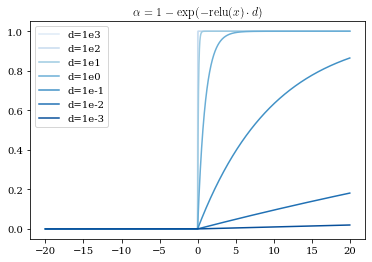

In [5]:
fig, ax = plt.subplots()
blue_shades = sns.color_palette("Blues", 7)
for distance_scale in [1e3, 1e2, 1e1, 1e0, 1e-1, 1e-2, 1e-3]:
    sigmas = compute_alpha(torch.relu, raw_features, distance_scale)
    ax.plot(raw_features, sigmas, label=f"d={pretty_d[distance_scale]}", color=blue_shades.pop(0))

ax.set_title(r"$\alpha = 1 - \exp(-\mathrm{relu}(x) \cdot d)$", fontsize=12, usetex=True)
ax.legend(fontsize=10)
plt.savefig('relu.pdf', bbox_inches='tight', dpi=300)
plt.show()

CDF Plot of Nerf-Pytorch on Lego

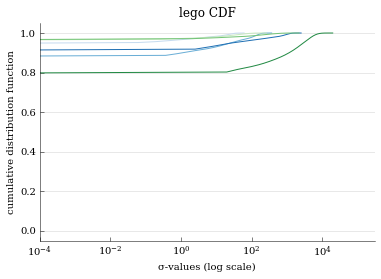

In [14]:
fig, ax = plt.subplots()
blue_shades = sns.color_palette("Blues", 3)
green_shades = sns.color_palette("Greens", 3)
bins_count = 1000

sns.despine()
ax.set_xscale('log')
ax.set_xlabel("σ-values (log scale)")
ax.set_ylabel("cumulative distribution function")
ax.set_title(f"lego CDF", fontsize=12)

mapping = {
    0: 0.1,
    1: 1.0,
    2: 10.0
}

for mlp in ['coarse', 'fine']:
    colors = blue_shades if mlp == 'coarse' else green_shades
    for i in reversed(range(3)):
        sigmas = torch.load(f"{mapping[i]}_{mlp}.pt")
        cdf, bins = compute_cdf(sigmas, bins_count)
        cdf = torch.cat([torch.tensor([0.0]), cdf])
        ax.plot(bins, cdf, linewidth=1.0, color=colors[2-i])

bottom, top = ax.get_ylim()
ax.set_ylim([bottom, top])
ax.set_xlim([1e-4, 3e5])
ax.minorticks_off()
for spine in ax.spines.values():
    spine.set_linewidth(0.5)
    spine.set_color('black')
ax.tick_params(direction='in', axis='both', width=0.5, color='black', length=4)
ax.yaxis.grid(True, which='both', linewidth=0.5, color='lightgray')

fig.savefig(f"lego_cdf.pdf", dpi=300, bbox_inches='tight')
plt.show()

5-Pane 50th-percentile $\sigma$ Visualization from Nerfacto on Garden

In [112]:
from matplotlib.colors import AsinhNorm, LogNorm, Normalize
from mpl_toolkits.axes_grid1 import ImageGrid, make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import LogFormatter

def process_sigmas(sigmas, lower=1e-4, upper=1e4):
    sigmas[sigmas < lower] = lower
    sigmas[sigmas > upper] = upper
    return sigmas

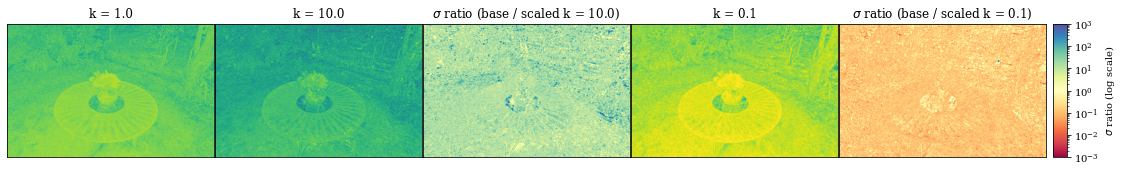

In [116]:
lower, upper = 1e-4, 1e4
ratio_lower, ratio_upper = 1e-3, 1e3

fig = plt.figure(figsize=(19, 4))
grid = ImageGrid(
    fig, 111, nrows_ncols=(1, 5),
    cbar_location="right", cbar_mode="edge", cbar_size="7%", cbar_pad=0.10,
)

k_01 = process_sigmas(np.load("garden_01.npy").squeeze(), lower, upper)
k_1 = process_sigmas(np.load("garden_1.npy").squeeze(), lower, upper)
k_10 = process_sigmas(np.load("garden_10.npy").squeeze(), lower, upper)

height, width = k_01.shape

cb_base = grid[0].imshow(k_1.reshape(height, width), cmap='viridis', norm=LogNorm(lower, upper))
grid[0].set_title(f"k = 1.0", fontsize=12)
grid[0].get_xaxis().set_visible(False)
grid[0].get_yaxis().set_visible(False)

grid[1].imshow(k_10.reshape(height, width), cmap='viridis', norm=LogNorm(lower, upper))
grid[1].set_title(f"k = 10.0", fontsize=12)
grid[1].get_xaxis().set_visible(False)
grid[1].get_yaxis().set_visible(False)

high_ratio = k_1 / k_10
high_ratio = process_sigmas(high_ratio, ratio_lower, ratio_upper)
cb_ratio = grid[2].imshow(high_ratio, cmap='Spectral', norm=LogNorm(ratio_lower, ratio_upper))
grid[2].set_title(r"$\sigma$ ratio (base / scaled k = 10.0)", fontsize=12)
grid[2].get_xaxis().set_visible(False)
grid[2].get_yaxis().set_visible(False)

grid[3].imshow(k_01.reshape(height, width), cmap='viridis', norm=LogNorm(lower, upper))
grid[3].set_title(f"k = 0.1", fontsize=12)
grid[3].get_xaxis().set_visible(False)
grid[3].get_yaxis().set_visible(False)

low_ratio = k_1 / k_01
low_ratio = process_sigmas(low_ratio, ratio_lower, ratio_upper)
grid[4].imshow(low_ratio, cmap='Spectral', norm=LogNorm(ratio_lower, ratio_upper))
grid[4].set_title(r"$\sigma$ ratio (base / scaled k = 0.1)", fontsize=12)
grid[4].get_xaxis().set_visible(False)
grid[4].get_yaxis().set_visible(False)

# plt.colorbar(cb_base, cax=grid.cbar_axes[1], label=r"$\sigma$ (log scale)")
plt.colorbar(cb_ratio, cax=grid.cbar_axes[0], label=r"$\sigma$ ratio (log scale)")
plt.savefig(f"garden.pdf", dpi=300, bbox_inches='tight')
plt.show()

5-Pane 50th-percentile $\sigma$ Visualization from Nerfacto on Bicycle

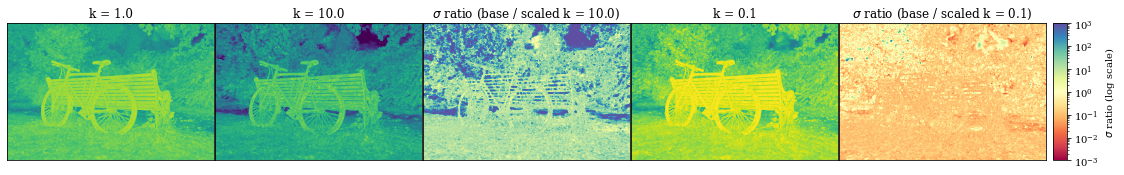

In [115]:
lower, upper = 1e-4, 1e4
ratio_lower, ratio_upper = 1e-3, 1e3

fig = plt.figure(figsize=(19, 4))
grid = ImageGrid(
    fig, 111, nrows_ncols=(1, 5),
    cbar_location="right", cbar_mode="edge", cbar_size="7%", cbar_pad=0.10,
)

k_01 = process_sigmas(np.load("bicycle_01.npy").squeeze(), lower, upper)
k_1 = process_sigmas(np.load("bicycle_1.npy").squeeze(), lower, upper)
k_10 = process_sigmas(np.load("bicycle_10.npy").squeeze(), lower, upper)

height, width = k_01.shape

cb_base = grid[0].imshow(k_1.reshape(height, width), cmap='viridis', norm=LogNorm(lower, upper))
grid[0].set_title(f"k = 1.0", fontsize=12)
grid[0].get_xaxis().set_visible(False)
grid[0].get_yaxis().set_visible(False)

grid[1].imshow(k_10.reshape(height, width), cmap='viridis', norm=LogNorm(lower, upper))
grid[1].set_title(f"k = 10.0", fontsize=12)
grid[1].get_xaxis().set_visible(False)
grid[1].get_yaxis().set_visible(False)

high_ratio = k_1 / k_10
high_ratio = process_sigmas(high_ratio, ratio_lower, ratio_upper)
cb_ratio = grid[2].imshow(high_ratio, cmap='Spectral', norm=LogNorm(ratio_lower, ratio_upper))
grid[2].set_title(r"$\sigma$ ratio (base / scaled k = 10.0)", fontsize=12)
grid[2].get_xaxis().set_visible(False)
grid[2].get_yaxis().set_visible(False)

grid[3].imshow(k_01.reshape(height, width), cmap='viridis', norm=LogNorm(lower, upper))
grid[3].set_title(f"k = 0.1", fontsize=12)
grid[3].get_xaxis().set_visible(False)
grid[3].get_yaxis().set_visible(False)

low_ratio = k_1 / k_01
low_ratio = process_sigmas(low_ratio, ratio_lower, ratio_upper)
grid[4].imshow(low_ratio, cmap='Spectral', norm=LogNorm(ratio_lower, ratio_upper))
grid[4].set_title(r"$\sigma$ ratio (base / scaled k = 0.1)", fontsize=12)
grid[4].get_xaxis().set_visible(False)
grid[4].get_yaxis().set_visible(False)

# plt.colorbar(cb_base, cax=grid.cbar_axes[1], label=r"$\sigma$ (log scale)")
plt.colorbar(cb_ratio, cax=grid.cbar_axes[0], label=r"$\sigma$ ratio (log scale)")
plt.savefig(f"bicycle.pdf", dpi=300, bbox_inches='tight')
plt.show()

5-Pane 50th-percentile $\sigma$ Visualization from Nerfacto on Garden and Bicycle with both colorbar schemes

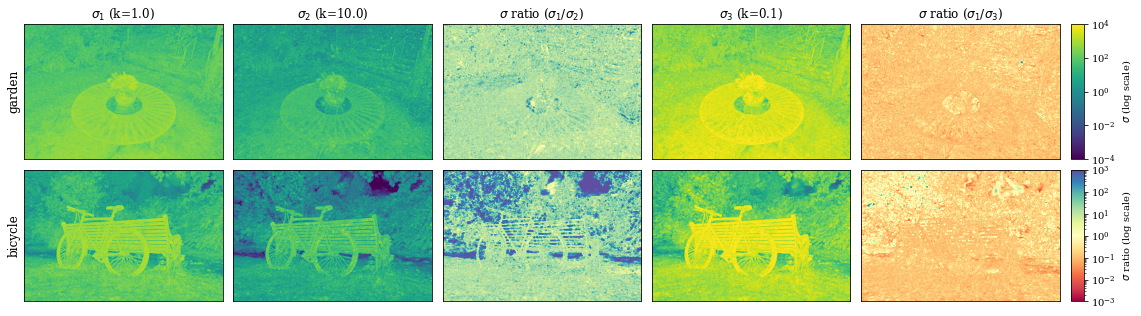

In [138]:
lower, upper = 1e-4, 1e4
ratio_lower, ratio_upper = 1e-3, 1e3

fig = plt.figure(figsize=(19, 8))
grid = ImageGrid(
    fig, 111, nrows_ncols=(2, 5), axes_pad=0.15,
    cbar_location="right", cbar_mode="edge", cbar_size="7%", cbar_pad=0.15,
)

# extract garden data
k_01 = process_sigmas(np.load("garden_01.npy").squeeze(), lower, upper)
k_1 = process_sigmas(np.load("garden_1.npy").squeeze(), lower, upper)
k_10 = process_sigmas(np.load("garden_10.npy").squeeze(), lower, upper)
height, width = k_01.shape

cb_base = grid[0].imshow(k_1.reshape(height, width), cmap='viridis', norm=LogNorm(lower, upper))
grid[0].set_title(r"$\sigma_1$ (k=1.0)", fontsize=12)
grid[1].imshow(k_10.reshape(height, width), cmap='viridis', norm=LogNorm(lower, upper))
grid[1].set_title(r"$\sigma_2$ (k=10.0)", fontsize=12)
grid[3].imshow(k_01.reshape(height, width), cmap='viridis', norm=LogNorm(lower, upper))
grid[3].set_title(r"$\sigma_3$ (k=0.1)", fontsize=12)

high_ratio = process_sigmas(k_1 / k_10, ratio_lower, ratio_upper)
low_ratio = process_sigmas(k_1 / k_01, ratio_lower, ratio_upper)
cb_ratio = grid[2].imshow(high_ratio, cmap='Spectral', norm=LogNorm(ratio_lower, ratio_upper))
grid[2].set_title(r"$\sigma$ ratio ($\sigma_1 / \sigma_2$)", fontsize=12)
grid[4].imshow(low_ratio, cmap='Spectral', norm=LogNorm(ratio_lower, ratio_upper))
grid[4].set_title(r"$\sigma$ ratio ($\sigma_1 / \sigma_3$)", fontsize=12)

# extract bicycle data
k_01 = process_sigmas(np.load("bicycle_01.npy").squeeze(), lower, upper)
k_1 = process_sigmas(np.load("bicycle_1.npy").squeeze(), lower, upper)
k_10 = process_sigmas(np.load("bicycle_10.npy").squeeze(), lower, upper)
height, width = k_01.shape

grid[5].imshow(k_1.reshape(height, width), cmap='viridis', norm=LogNorm(lower, upper))
grid[6].imshow(k_10.reshape(height, width), cmap='viridis', norm=LogNorm(lower, upper))
grid[8].imshow(k_01.reshape(height, width), cmap='viridis', norm=LogNorm(lower, upper))

high_ratio = process_sigmas(k_1 / k_10, ratio_lower, ratio_upper)
low_ratio = process_sigmas(k_1 / k_01, ratio_lower, ratio_upper)
grid[7].imshow(high_ratio, cmap='Spectral', norm=LogNorm(ratio_lower, ratio_upper))
grid[9].imshow(low_ratio, cmap='Spectral', norm=LogNorm(ratio_lower, ratio_upper))

for index in range(10):
    grid[index].get_xaxis().set_visible(False)
    if index not in [0, 5]:
        grid[index].get_yaxis().set_visible(False)

# colorbars and labels
plt.colorbar(cb_base, cax=grid.cbar_axes[0], label=r"$\sigma$ (log scale)")
plt.colorbar(cb_ratio, cax=grid.cbar_axes[1], label=r"$\sigma$ ratio (log scale)")
grid[0].set_ylabel("garden", fontsize=12)
grid[0].set_yticks([])
grid[5].set_ylabel("bicycle", fontsize=12)
grid[5].set_yticks([])

plt.savefig(f"combination.pdf", dpi=300, bbox_inches='tight')
plt.show()

TensoRF 5-pane 50th-percentile visualizations